In [2]:
# Importing Libraries

from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import math
import sys
import warnings
from sklearn.metrics import accuracy_score
from tabulate import tabulate 
from sklearn.externals import joblib 
import joblib as job
import pickle as pk

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
# Utility Functions

def loaddata(path):
  data = loadmat(path)
  data_label = data['labels'].reshape(10000,1)
  data_image = data['samples'].reshape(10000,2)
  df_i = pd.DataFrame(data_image,columns=['D1','D2'])
  df_l = pd.DataFrame(data_label,columns=['Label'])
  df = pd.concat([df_i,df_l],axis=1) 
  return df

def plot(df): 
  plt.figure(figsize=(10,5))
  sn.set(style = 'whitegrid')
  sn.scatterplot(data= df,x='D1',y='D2',hue='Label')
  plt.xlabel('D1')
  plt.ylabel('D2')
  plt.show()  

def TrainTestSplit(Data,r):
  Test_Data = Data.sample(n = int(r*len(Data)),random_state=10)
  Training_Data = pd.concat([Data,Test_Data])
  Training_Data = Training_Data.drop_duplicates(keep=False)   
  return Training_Data , Test_Data  

def accuracy(actual,predicted):
    
      c = 0
      for i in range(len(actual)):
          if(actual[i]!=predicted[i]):
              continue
          else:    
              c = c + 1
      return c/len(actual)

def NfoldSplit(Data,n):
  NewData = []
  size = (Data.shape[0]//n)+1
  for i in range(n):
    T = Data[i*size:i*size+size]
    NewData.append(T)
  return NewData

def plotdecisionbounday(X,Y,s,sup,kernel,C,g=None):
  X = X.to_numpy()
  Y = Y.to_numpy()
  d1min = X[:,0].min()-0.1
  d1max = X[:,0].max()
  d2min = X[:,1].min()-0.1
  d2max = X[:,1].max()
  d1 = np.arange(d1min,d1max,0.01)
  d2 = np.arange(d2min,d2max,0.01)

  grid1, grid2 = np.meshgrid(d1,d2)
  t1 = grid1.ravel()
  t2 = grid2.ravel()
  #plt.figure(figsize=(13,8))

  xy = np.vstack([t1, t2]).T
  M = sup.decision_function(xy).reshape(grid1.shape)

  plt.contour(grid1, grid2, M ,levels=[-1, 0, 1],linestyles=['--', '-', '--'],colors = 'black',alpha =0.5
              ,edgecolor='black',linewidth=2 )
  plt.scatter(sup.support_vectors_[:, 0], sup.support_vectors_[:, 1],cmap=plt.cm.Paired , 
             zorder=5 ,  edgecolor='black',linewidth=1)

  plt.xlabel('D1')
  plt.ylabel('D2')

  if  g is None:
    title = 'Plot with Kernel : '+str(kernel) + ' , C : ' + str(C)
    plt.title(title)
  else:
    title = 'Plot with Kernel : '+str(kernel) + ' , C : ' + str(C) + ' , Gamma : '+str(g)
    plt.title(title)  
  plt.show()

def Classwise_Accuracy(Ypred,Yact):
  C = np.array(Yact)
  C = list(np.unique(C))
  C.sort()
  
  Main_Acc = []
  for i in range(len(C)):
    Pred = []
    Act = []
    for j in range(len(Ypred)):
      if(Yact[j]==C[i]):
        Pred.append(Ypred[j])
        Act.append(Yact[j])
    acc = round(accuracy(Act,Pred),3)
    acc = acc*100    
    Main_Acc.append(acc)
  return Main_Acc

warnings.filterwarnings("ignore")

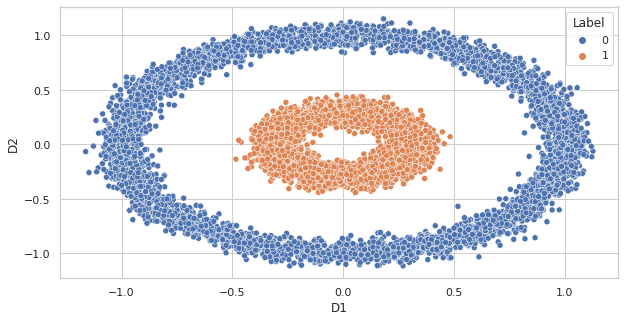

In [ ]:
# 2.a.
path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/dataset_a.mat'
df = loaddata(path)
plot(df)
Train,Test = TrainTestSplit(df,0.2)
X = ['D1','D2']
Y = 'Label'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# User Defined SVM Class

class SVM():

  def __init__(self,C=1,kernel='linear',method='binary',max_iter=-1,g=0.3):
    self.kernel = kernel
    self.method = method
    self.C = C
    self.max_iter = max_iter
    self.g = g
    
  def Fit(self,XTrain,YTrain):
    
    if self.method == 'binary':    
      s = SVC(C = self.C ,kernel = self.kernel ,max_iter = self.max_iter , random_state=10,gamma = self.g)
      s.fit(XTrain,YTrain)
      if self.kernel == 'linear':
        self.coff = s.coef_
        self.bias = s.intercept_
      elif self.kernel == 'rbf':
        self.obj = s
    
    elif self.method =='ovr':
      s = SVC(C = self.C ,kernel = self.kernel ,max_iter = self.max_iter , random_state=10,gamma = self.g)
      s.fit(XTrain,YTrain)
      if self.kernel == 'linear':
        self.coff = s.coef_
        self.bias = s.intercept_
      elif self.kernel == 'rbf':
        self.obj = s

    return s

  def  Predict(self,XTest):
    if self.method == 'binary' and self.kernel == 'linear':
      out = np.dot(XTest,self.coff.T) + self.bias
      out =  np.where(out>=0,1,0) 
    elif self.method == 'binary' and  self.kernel == 'rbf':
      out = self.obj.decision_function(XTest)
      out =  np.where(out>=0,1,0) 
    elif self.method =='ovr':
      out = self.obj.decision_function(XTest)
      out = np.exp(-out) + 1
      out = 1.0/out
    return out


In [5]:
#2.b.
# Saving Model

paths = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/dataset_a.mat'
df = loaddata(paths)
Train,Test = TrainTestSplit(df,0.2)
X = ['D1','D2']
Y = 'Label'

C = [3, 30,300]
TestAcc1 = []

# for c in C:
#   s1 = SVM(C=c)
#   s11 = s1.Fit(Train[X],Train[Y])
  
#   path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/2.2/'+str(c)
#   path1 = str(path+'s1.pkl')
#   path2 = str(path+'s11.pkl')
#   pk.dump(s1, open(path1, "wb"))
#   pk.dump(s11, open(path2, "wb"))



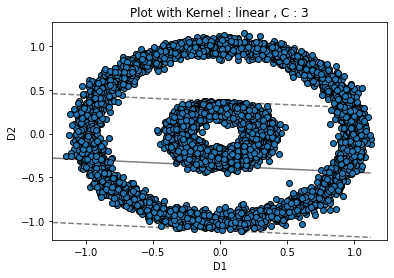

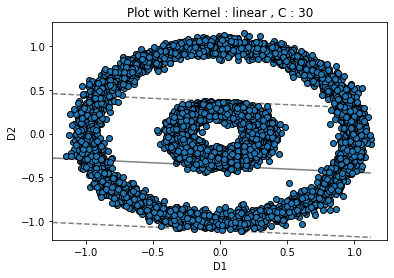

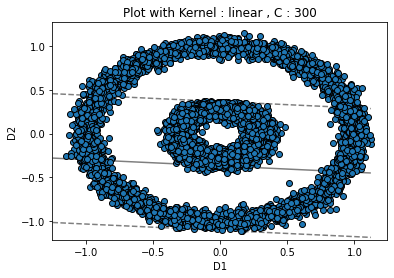

Table Stats for Kernel : Linear 
+----+--------------------+-----+
|    |   Testing Accuracy |   C |
|----+--------------------+-----|
|  0 |              66.25 |   3 |
|  1 |              66.25 |  30 |
|  2 |              66.25 | 300 |
+----+--------------------+-----+
Maximum Testing Accuracy :  66.25 %
Optimal Value of C :  3


In [6]:
# Loading Models

for c in C:

  path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/2.2/'+str(c)
  path1 = str(path+'s1.pkl')
  path2 = str(path+'s11.pkl')

  s1 = pk.load(open(path1,'rb')) 
  s11 = pk.load(open(path2,'rb'))
  YPred = s1.Predict(Test[X])
  acc = (accuracy(list(Test[Y]),list(YPred))*100)
  acc = round(acc,3)
  TestAcc1.append(acc)
  plotdecisionbounday(Train[X],Train[Y],s1,s11,'linear',C =c)

print('Table Stats for Kernel : Linear ')
Table = pd.DataFrame()
Table['Testing Accuracy'] =   TestAcc1
Table['C'] = C
print(tabulate(Table, tablefmt = 'psql',headers = 'keys'))  

optC1 = C[TestAcc1.index(max(TestAcc1))]
print('Maximum Testing Accuracy : ',round(max(TestAcc1),3),'%')
print('Optimal Value of C : ',optC1)

In [7]:
# 2.c.
# Saving Models

paths = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/dataset_a.mat'
df = loaddata(paths)
Train,Test = TrainTestSplit(df,0.2)
X = ['D1','D2']
Y = 'Label'

C = [3, 30,300]
gamma = [0.3 ,0.03]

TestAcc2 = []
para2 = []

# for c in C:
#   for g in gamma:
#     s1 = SVM(C=c ,g = g ,kernel = 'rbf')
#     s11 = s1.Fit(Train[X],Train[Y])
  
#     path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/2.3/'+str(c)+str(g)
#     path1 = str(path+'s1.pkl')
#     path2 = str(path+'s11.pkl')
#     pk.dump(s1, open(path1, "wb"))
#     pk.dump(s11, open(path2, "wb"))

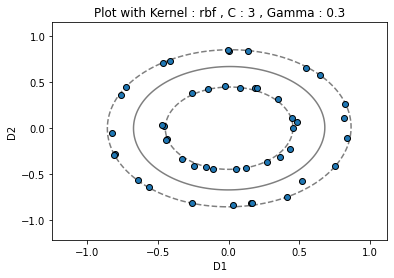

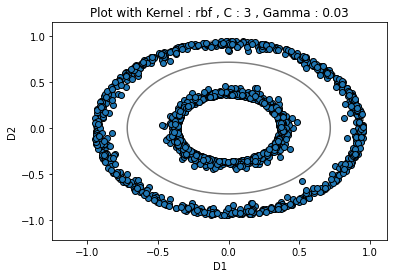

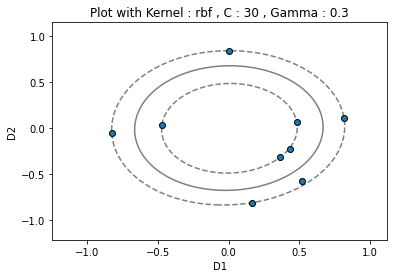

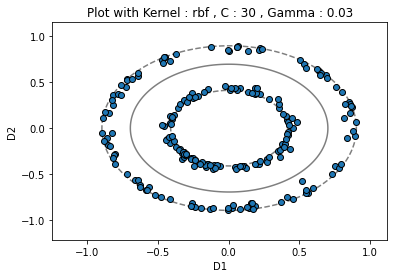

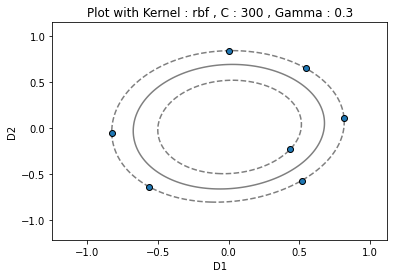

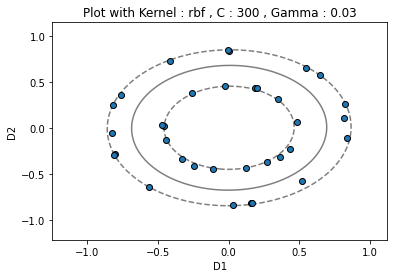

	Table Stats for Kernel : RBF 
+----+-----+---------+--------------------+
|    |   C |   Gamma |   Testing Accuracy |
|----+-----+---------+--------------------|
|  0 |   3 |    0.3  |                100 |
|  1 |   3 |    0.03 |                100 |
|  2 |  30 |    0.3  |                100 |
|  3 |  30 |    0.03 |                100 |
|  4 | 300 |    0.3  |                100 |
|  5 | 300 |    0.03 |                100 |
+----+-----+---------+--------------------+
Maximum Testing Accuracy :  100.0 %
Optimal Value of C :  3
Optimal Value of gamma :  0.3


In [8]:
# Loading Models 
for c in C:
  for g in gamma:

    path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/2.3/'+str(c)+str(g)
    path1 = str(path+'s1.pkl')
    path2 = str(path+'s11.pkl')

    s2 = pk.load(open(path1,'rb')) 
    s22 = pk.load(open(path2,'rb'))
    YPred = s2.Predict(Test[X])
    acc = (accuracy(list(Test[Y]),list(YPred))*100)
    TestAcc2.append(acc)
    para2.append([c,g,acc])
    plotdecisionbounday(Train[X],Train[Y],s2,s22,'rbf',C =c,g = g)

print('\tTable Stats for Kernel : RBF ')
Table = pd.DataFrame(para2,columns=['C','Gamma','Testing Accuracy'])
print(tabulate(Table, tablefmt = 'psql',headers = 'keys')) 
opt2 = para2[TestAcc2.index(max(TestAcc2))]
optC2 = opt2[0]
optg2 = opt2[1]
print('Maximum Testing Accuracy : ',max(TestAcc2),'%')
print('Optimal Value of C : ',optC2)
print('Optimal Value of gamma : ',optg2)

In [ ]:
# 2.d.
# Saving Models

# s3 = LinearSVC(C=optC1,random_state=10)
# s3.fit(Train[X],Train[Y])
# path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/2.4/'+str(optC1)
# path1 = str(path+'s.pkl')
# pk.dump(s3, open(path1, "wb"))

# s4 = SVC(C=optC2,random_state=10, gamma = optg2)
# s4.fit(Train[X],Train[Y])
# path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/2.4/'+str(optC2)+str(optg2)
# path1 = str(path+'s.pkl')
# pk.dump(s4, open(path1, "wb"))

In [9]:
# Loading Models

print('Using Sklearn predict :')

path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/2.4/'+str(optC1)
path1 = str(path+'s.pkl')
s3 = pk.load(open(path1,'rb')) 
YPred = s3.predict(Test[X])
acc = accuracy_score(list(Test[Y]),list(YPred))*100 
print('\nKernel : Linear ')
print('Optimal Value of C : ',optC1)
print('Testing Accuracy : ',round(acc,3),'%')

path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/2.4/'+str(optC2) + str(optg2)
path1 = str(path+'s.pkl')
s4 = pk.load(open(path1,'rb')) 
YPred = s4.predict(Test[X])
acc = accuracy_score(list(Test[Y]),list(YPred))*100 
print('\nKernel : RBF ')
print('Optimal Value of C : ',optC2)
print('Optimal Value of gamma : ',optg2)
print('Testing Accuracy : ',round(acc,3),'%')

Using Sklearn predict :

Kernel : Linear 
Optimal Value of C :  3
Testing Accuracy :  63.5 %

Kernel : RBF 
Optimal Value of C :  3
Optimal Value of gamma :  0.3
Testing Accuracy :  100.0 %


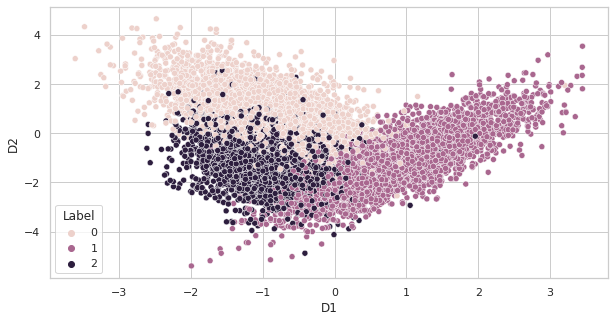

In [ ]:
# 3.a.
path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/dataset_b.mat'
Data = loaddata(path)
plot(Data)

In [10]:
# 3.b.
# Saving Models

C = [3, 30,300]
gamma = [0.3 ,0.03]

paths = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/dataset_b.mat'
Data = loaddata(paths)
split = 5

Cl = list(Data.Label.unique())
Label = list(Data['Label'])
Data = pd.get_dummies(Data, columns= ['Label'],prefix_sep='' , prefix='')
Data['Label'] = Label

NewData = NfoldSplit(Data,split)  
NewData_C = NewData.copy()
X = ['D1','D2']
Y = ['0' ,'1' , '2']

TestAcc = []

Cl = list(Data.Label.unique())
Cl.sort()

Fold = []
TA = []
Cval = []
Gval = []

ClTe = [] 

# for i in range(split):  
#   NewData = NewData_C.copy()  
#   Test = NewData.pop(i)
#   Train = pd.concat(NewData) 

#   XTrain = Train[X]
#   XTest = Test[X]
#   XTrain = XTrain.to_numpy()
#   XTest = XTest.to_numpy()
  
#   TestAcc = []
#   para = []
  
#   for c in C:
#     for g in gamma:
      
#       YPredM = []
#       YPredFinal = []
      
#       for cl in Cl:
#         YTrain = Train[str(cl)]
#         YTest = Test[str(cl)] 
#         YTrain = YTrain.to_numpy()
#         YTest = YTest.to_numpy()
  
#         s = SVM(C=c ,g = g , max_iter=-1,kernel = 'rbf',method ='ovr')
#         ss = s.Fit(XTrain,YTrain)
#         path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/3.2/'+str(i)+str(c) + str(g)+str(cl)
#         path1 = str(path+'s.pkl')
#         pk.dump(s, open(path1, "wb"))
        
      

In [11]:
# Loading Models

C = [3, 30,300]
gamma = [0.3 ,0.03]

Data = loaddata(paths)
split = 5

Cl = list(Data.Label.unique())
Label = list(Data['Label'])
Data = pd.get_dummies(Data, columns= ['Label'],prefix_sep='' , prefix='')
Data['Label'] = Label

NewData = NfoldSplit(Data,split)  
NewData_C = NewData.copy()
X = ['D1','D2']
Y = ['0' ,'1' , '2']

TestAcc = []

Cl = list(Data.Label.unique())
Cl.sort()

Fold = []
TA = []
Cval = []
Gval = []

ClTe = [] 

for i in range(split):  
  NewData = NewData_C.copy()  
  Test = NewData.pop(i)
  XTest = Test[X]
  XTest = XTest.to_numpy()
  
  TestAcc = []
  para = []
  
  for c in C:
    for g in gamma:
      
      YPredM = []
      YPredFinal = []
      
      for cl in Cl:

        path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/3.2/'+str(i)+str(c) + str(g)+str(cl)
        path1 = str(path+'s.pkl')
        s = pk.load(open(path1,'rb')) 
        
        YPred = s.Predict(XTest)

        YPredM.append(YPred)
        
      YPredDf = pd.DataFrame()
      for cli in range(len(Cl)):
        YPredDf[Cl[cli]] = YPredM[cli]
      
      u = YPredDf.idxmax(axis = 1) 

      for h in range(len(u)):
        YPredFinal.append(int(Y[u[h]]))

      
      acc = (accuracy(list(YPredFinal),list(Test['Label']))*100)
      acc = round(acc,3)

      TestAcc.append(acc)
      para.append([c,g])

  ClTe.append([i+1]+Classwise_Accuracy(list(YPredFinal),list(Test['Label']))) 
  opt = para[TestAcc.index(max(TestAcc))]
  optC = opt[0]
  optg = opt[1]

  Fold.append(i+1)
  TA.append(max(TestAcc))
  Cval.append(optC)
  Gval.append(optg)

col = ['Fold'] + Cl 
Class_Test1 = pd.DataFrame(ClTe,columns=col)

NMainTable1 = pd.DataFrame()
print('\t\tTable Stats for OVR Method :')
NMainTable1['Fold'] = Fold
NMainTable1['Testing Accuracy'] = TA
NMainTable1['C'] = Cval 
NMainTable1['Gamma'] = Gval
print(tabulate(NMainTable1, tablefmt = 'psql',headers = 'keys'))  
print('Mean Testing Accuracy over 5 folds :',round(NMainTable1['Testing Accuracy'].mean(),3),'%')

print('\n\tClasswise Accuracy for OVR Method :')
print(tabulate(Class_Test1, tablefmt = 'psql',headers = 'keys'))  
print('Mean Classwise Testing Accuracy for class = 0  :',round(Class_Test1[0].mean(),3),'%')
print('Mean Classwise Testing Accuracy for class = 1  :',round(Class_Test1[1].mean(),3),'%')
print('Mean Classwise Testing Accuracy for class = 2  :',round(Class_Test1[2].mean(),3),'%')

		Table Stats for OVR Method :
+----+--------+--------------------+-----+---------+
|    |   Fold |   Testing Accuracy |   C |   Gamma |
|----+--------+--------------------+-----+---------|
|  0 |      1 |             88.406 |   3 |     0.3 |
|  1 |      2 |             87.156 |   3 |     0.3 |
|  2 |      3 |             87.806 | 300 |     0.3 |
|  3 |      4 |             87.406 |   3 |     0.3 |
|  4 |      5 |             87.074 |  30 |     0.3 |
+----+--------+--------------------+-----+---------+
Mean Testing Accuracy over 5 folds : 87.57 %

	Classwise Accuracy for OVR Method :
+----+--------+------+------+------+
|    |   Fold |    0 |    1 |    2 |
|----+--------+------+------+------|
|  0 |      1 | 85.7 | 95.1 | 83.6 |
|  1 |      2 | 85.9 | 95.1 | 80.7 |
|  2 |      3 | 85.4 | 95.7 | 81.7 |
|  3 |      4 | 85.3 | 95.2 | 81.4 |
|  4 |      5 | 84.8 | 94.9 | 81   |
+----+--------+------+------+------+
Mean Classwise Testing Accuracy for class = 0  : 85.42 %
Mean Classwise Test

In [ ]:
# 3.c.
# Saving Models

C = [3,30,300]
gamma = [0.3 , 0.03]

Data = loaddata(paths)
Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
split = 5
        
Cl = list(Data.Label.unique())
Cl.sort()

Fold = []
TA = []
Cval = []
Gval = []

Label = list(Data['Label'])
Data['Label'] = Label
Class_Com = []

for p in range(len(Cl)-1):    
  for q in range(p+1,len(Cl)):
    Class_Com.append(str(int(Cl[p]))+str(int(Cl[q])))
    

NewData = NfoldSplit(Data,split)  
NewData_C = NewData.copy()

ClTe = []

# for i in range(split):   

#   NewData = NewData_C.copy()  
#   Test = NewData.pop(i)
#   Train = pd.concat(NewData) 
          
#   Train = Train.to_numpy().astype(float)
#   Test = Test.to_numpy().astype(float)

  
#   Train_Model = []

#   TestAcc = []
#   para = []        
  
#   for c in C:
#     for g in gamma:
      
#       Test_Model = []
      
#       for p in range(len(Cl)-1):  
#         for q in range(p+1,len(Cl)):
          
#           NewTrain = Train[np.logical_or(Train[:,2]==Cl[p] ,Train[:,2]==Cl[q])]
#           NewTrain[:,2] =  np.where(NewTrain[:,2]==Cl[p],1,0)
          
#           s = SVM(C=c,g=g , kernel = 'rbf',method ='ovr')
#           ss = s.Fit(NewTrain[:,:2],NewTrain[:,2])

#           path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/3.3/'+str(i)+str(c) + str(g)+str(p)+str(q)
#           path1 = str(path+'s.pkl')
#           pk.dump(s, open(path1, "wb"))
  

In [ ]:
# Loading Models

C = [3,30,300]
gamma = [0.3 , 0.03]

Data = loaddata(paths)
Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
split = 5
        
Cl = list(Data.Label.unique())
Cl.sort()

Fold = []
TA = []
Cval = []
Gval = []

Label = list(Data['Label'])
Data['Label'] = Label
Class_Com = []

for p in range(len(Cl)-1):    
  for q in range(p+1,len(Cl)):
    Class_Com.append(str(int(Cl[p]))+str(int(Cl[q])))
    

NewData = NfoldSplit(Data,split)  
NewData_C = NewData.copy()

ClTe = []

for i in range(split):   

  NewData = NewData_C.copy()  
  Test = NewData.pop(i)
  Test = Test.to_numpy().astype(float)
  
  TestAcc = []
  para = []        
  
  for c in C:
    for g in gamma:
      
      Test_Model = []
      
      for p in range(len(Cl)-1):  
        for q in range(p+1,len(Cl)):
          
          path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/3.3/'+str(i)+str(c) + str(g)+ str(p)+str(q)
          path1 = str(path+'s.pkl')
          s = pk.load(open(path1,'rb')) 

          Test_Pred = s.Predict(Test[:,:2])
          Test_Pred = np.where(Test_Pred>=0.5,p,q)
          Test_Model.append(list(Test_Pred))

      Test_Pred_Fold = pd.DataFrame()
      for e in range(len(Class_Com)):
        Test_Pred_Fold[Class_Com[e]] = Test_Model[e]

      te = [] 
      for l in range(len(Test_Pred_Fold)):
        ax = list(Test_Pred_Fold.iloc[l])
        te.append(max(ax,key=ax.count))  
      
      acc = accuracy(list(Test[:,2]),list(te))*100
      acc = round(acc,3)
      TestAcc.append(acc)
      para.append([c,g])

  ClTe.append([i+1]+Classwise_Accuracy(list(te) , list(Test[:,2]))) 

  opt = para[TestAcc.index(max(TestAcc))]
  optC = opt[0]
  optg = opt[1]

  Fold.append(i+1)
  TA.append(max(TestAcc))
  Cval.append(optC)
  Gval.append(optg)

col = ['Fold'] + Cl 
Class_Test2 = pd.DataFrame(ClTe,columns=col)

NMainTable2 = pd.DataFrame()
print('\t\tTable Stats for OVO Method :')
NMainTable2['Fold'] = Fold
NMainTable2['Testing Accuracy'] = TA
NMainTable2['C'] = Cval 
NMainTable2['Gamma'] = Gval
print(tabulate(NMainTable2, tablefmt = 'psql',headers = 'keys'))  
print('Mean Testing Accuracy over 5 folds :',round(NMainTable2['Testing Accuracy'].mean(),3),'%')

print('\n\tClasswise Accuracy for OVO Method :')
print(tabulate(Class_Test2, tablefmt = 'psql',headers = 'keys'))  
print('Mean Classwise Testing Accuracy for class = 0  :',round(Class_Test2[0].mean(),3),'%')
print('Mean Classwise Testing Accuracy for class = 1  :',round(Class_Test2[1].mean(),3),'%')
print('Mean Classwise Testing Accuracy for class = 2  :',round(Class_Test2[2].mean(),3),'%')

		Table Stats for OVO Method :
+----+--------+--------------------+-----+---------+
|    |   Fold |   Testing Accuracy |   C |   Gamma |
|----+--------+--------------------+-----+---------|
|  0 |      1 |             88.556 |   3 |    0.3  |
|  1 |      2 |             87.206 | 300 |    0.3  |
|  2 |      3 |             87.956 |  30 |    0.3  |
|  3 |      4 |             87.256 |   3 |    0.3  |
|  4 |      5 |             87.224 |  30 |    0.03 |
+----+--------+--------------------+-----+---------+
Mean Testing Accuracy over 5 folds : 87.64 %

	Classwise Accuracy for OVO Method :
+----+--------+------+------+------+
|    |   Fold |    0 |    1 |    2 |
|----+--------+------+------+------|
|  0 |      1 | 86.5 | 95.9 | 82.1 |
|  1 |      2 | 86.5 | 95.4 | 79.9 |
|  2 |      3 | 86.5 | 95.8 | 80.7 |
|  3 |      4 | 85.3 | 95.5 | 80.5 |
|  4 |      5 | 85.1 | 95.2 | 80.7 |
+----+--------+------+------+------+
Mean Classwise Testing Accuracy for class = 0  : 85.98 %
Mean Classwise Test

In [ ]:
# 3.d. OVR
# Saving Model

paths = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/dataset_b.mat'
df = loaddata(paths)

NewData = NfoldSplit(df,split)  
NewData_C = NewData.copy()

X = ['D1','D2']
Y = 'Label'

Fold = []
TA = []

ClTe = []
Cl = list(Data.Label.unique())
Cl.sort()

# for i in range(split):

#   NewData = NewData_C.copy()  
  
#   Test = NewData.pop(i)
#   Train = pd.concat(NewData) 

#   s5 = SVC(C=NMainTable1.iloc[i]['C'],decision_function_shape='ovr',random_state=10 , gamma = NMainTable1.iloc[i]['Gamma'])
#   s5.fit(Train[X],Train[Y])
#   path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/3.4/ovr'+str(i)
#   path1 = str(path+'s.pkl')
#   pk.dump(s5, open(path1, "wb"))
  

In [ ]:
# Loading Model

paths = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/dataset_b.mat'
df = loaddata(paths)

X = ['D1','D2']
Y = 'Label'

NewData = NfoldSplit(df,split)  
NewData_C = NewData.copy()

Fold = []
TA = []

ClTe = []
Cl = list(Data.Label.unique())
Cl.sort()

print('Using Sklearn predict with Method OVR :')
for i in range(split):
  
  NewData = NewData_C.copy()  
  Test = NewData.pop(i)
  
  path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/3.4/ovr'+str(i)
  path1 = str(path+'s.pkl')
  s5 = pk.load(open(path1,'rb')) 
  YPred = s5.predict(Test[X])
  acc = accuracy_score(list(Test[Y]),list(YPred))*100
  
  Fold.append(i+1)
  TA.append(round(acc,3))
  ClTe.append([i+1]+ Classwise_Accuracy(list(YPred) , list(Test[Y])))

col = ['Fold'] + Cl 
Class_Test3 = pd.DataFrame(ClTe,columns=col)

NMainTable3 = pd.DataFrame()
print('\t\tTable Stats for OVR Method :')
NMainTable3['Fold'] = Fold
NMainTable3['Testing Accuracy'] = TA
NMainTable3['C'] =  list(NMainTable1['C'])
NMainTable3['Gamma'] = list(NMainTable1['Gamma'])
print(tabulate(NMainTable3, tablefmt = 'psql',headers = 'keys'))  
print('Mean Testing Accuracy over 5 folds :',round(NMainTable3['Testing Accuracy'].mean(),3),'%')

print('\n\tClasswise Accuracy for OVR Method :')
print(tabulate(Class_Test3, tablefmt = 'psql',headers = 'keys'))  
print('Mean Classwise Testing Accuracy for class = 0  :',round(Class_Test3[0].mean(),3),'%')
print('Mean Classwise Testing Accuracy for class = 1  :',round(Class_Test3[1].mean(),3),'%')
print('Mean Classwise Testing Accuracy for class = 2  :',round(Class_Test3[2].mean(),3),'%')

Using Sklearn predict with Method OVR :
		Table Stats for OVR Method :
+----+--------+--------------------+-----+---------+
|    |   Fold |   Testing Accuracy |   C |   Gamma |
|----+--------+--------------------+-----+---------|
|  0 |      1 |             88.556 |   3 |     0.3 |
|  1 |      2 |             87.056 |   3 |     0.3 |
|  2 |      3 |             87.756 | 300 |     0.3 |
|  3 |      4 |             87.256 |   3 |     0.3 |
|  4 |      5 |             87.024 |  30 |     0.3 |
+----+--------+--------------------+-----+---------+
Mean Testing Accuracy over 5 folds : 87.53 %

	Classwise Accuracy for OVR Method :
+----+--------+------+------+------+
|    |   Fold |    0 |    1 |    2 |
|----+--------+------+------+------|
|  0 |      1 | 86.6 | 95.7 | 83.2 |
|  1 |      2 | 86.5 | 95.1 | 79.9 |
|  2 |      3 | 86.5 | 95.7 | 81.1 |
|  3 |      4 | 86   | 95.3 | 80.5 |
|  4 |      5 | 85.7 | 95.1 | 80.1 |
+----+--------+------+------+------+
Mean Classwise Testing Accuracy for 

In [ ]:
# 3.d. OVO
# Saving Model

paths = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/dataset_b.mat'
df = loaddata(paths)

NewData = NfoldSplit(df,split)  
NewData_C = NewData.copy()

X = ['D1','D2']
Y = 'Label'

Fold = []
TA = []

ClTe = []
Cl = list(Data.Label.unique())
Cl.sort()


# for i in range(split):

#   NewData = NewData_C.copy()  
#   Train = pd.concat(NewData)

#   s6 = SVC(C=NMainTable2.iloc[i]['C'],decision_function_shape='ovo',random_state=10 , gamma = NMainTable2.iloc[i]['Gamma'])
#   s6.fit(Train[X],Train[Y])

#   path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/3.4/ovo'+str(i)
#   path1 = str(path+'s.pkl')
#   pk.dump(s6, open(path1, "wb"))

  

In [ ]:
# Loading Models

paths = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/dataset_b.mat'
df = loaddata(paths)

NewData = NfoldSplit(df,split)  
NewData_C = NewData.copy()

X = ['D1','D2']
Y = 'Label'

Fold = []
TA = []

ClTe = []
Cl = list(Data.Label.unique())
Cl.sort()

print('Using Sklearn predict with Method OVO :')
for i in range(split):
  
  NewData = NewData_C.copy()  
  Test = NewData.pop(i)

  path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_3/Saved_Models/3.4/ovo'+str(i)
  path1 = str(path+'s.pkl')
  s6 = pk.load(open(path1,'rb')) 

  YPred = s6.predict(Test[X])
  acc = accuracy_score(list(Test[Y]),list(YPred))*100
  
  Fold.append(i+1)
  TA.append(round(acc,3))
  ClTe.append([i+1]+ Classwise_Accuracy(list(YPred) , list(Test[Y])))

col = ['Fold'] + Cl 
Class_Test4 = pd.DataFrame(ClTe,columns=col)

NMainTable4 = pd.DataFrame()
print('\t\tTable Stats for OVO Method :')
NMainTable4['Fold'] = Fold
NMainTable4['Testing Accuracy'] = TA
NMainTable4['C'] =  list(NMainTable2['C'])
NMainTable4['Gamma'] = list(NMainTable2['Gamma'])
print(tabulate(NMainTable4, tablefmt = 'psql',headers = 'keys'))  
print('Mean Testing Accuracy over 5 folds :',round(NMainTable4['Testing Accuracy'].mean(),3),'%')

print('\n\tClasswise Accuracy for OVO Method :')
print(tabulate(Class_Test4, tablefmt = 'psql',headers = 'keys'))  
print('Mean Classwise Testing Accuracy for class = 0  :',round(Class_Test4[0].mean(),3),'%')
print('Mean Classwise Testing Accuracy for class = 1  :',round(Class_Test4[1].mean(),3),'%')
print('Mean Classwise Testing Accuracy for class = 2  :',round(Class_Test4[2].mean(),3),'%')

Using Sklearn predict with Method OVO :
		Table Stats for OVO Method :
+----+--------+--------------------+-----+---------+
|    |   Fold |   Testing Accuracy |   C |   Gamma |
|----+--------+--------------------+-----+---------|
|  0 |      1 |             88.706 |   3 |    0.3  |
|  1 |      2 |             87.306 | 300 |    0.3  |
|  2 |      3 |             88.006 |  30 |    0.3  |
|  3 |      4 |             87.206 |   3 |    0.3  |
|  4 |      5 |             87.174 |  30 |    0.03 |
+----+--------+--------------------+-----+---------+
Mean Testing Accuracy over 5 folds : 87.68 %

	Classwise Accuracy for OVO Method :
+----+--------+------+------+------+
|    |   Fold |    0 |    1 |    2 |
|----+--------+------+------+------|
|  0 |      1 | 87.1 | 95.7 | 83.2 |
|  1 |      2 | 86.1 | 95.3 | 80.9 |
|  2 |      3 | 87.2 | 95.5 | 81.4 |
|  3 |      4 | 86   | 95.3 | 80.3 |
|  4 |      5 | 85.3 | 94.9 | 81.2 |
+----+--------+------+------+------+
Mean Classwise Testing Accuracy for 